## Project Title: Predicting Customer Churn: Uncovering Key Indicators and Retention Strategies


## Introduction

Customer churn, also known as customer attrition or customer turnover, refers to the percentage of customers who cease using a company's product or service within a given timeframe. Understanding and predicting customer churn is crucial for organizations as it directly impacts their profitability and growth. By identifying the factors that contribute to churn, businesses can develop effective retention strategies to mitigate this problem.

In this project, we will analyze a dataset containing various customer attributes such as gender, age, partner status, internet service provider, contract term, and payment method, among others. We aim to explore the relationship between these attributes and the likelihood of customer churn. By conducting a thorough analysis, we can uncover key indicators of churn and identify patterns that indicate a higher propensity for customers to leave the organization.

## Objectives

1.Build a classification model to predict customer churn and assess the likelihood of a customer leaving the organization.

2.Identify key indicators or factors that contribute to customer churn.

3.Formulate effective retention strategies based on the identified indicators to mitigate customer attrition.

## Hypothesis

**Null Hypothesis**: There is no significant relationship between the various customer attributes and the likelihood of customer churn.

**Alternatative Hypothesis**: There is a significant relationship between the various customer attributes and the likelihood of customer churn.

## Questions

1.What are the key indicators of customer churn in this dataset?

2.Is there any correlation between the type of internet service provider and customer churn?

3.What is the relationship between contract terms and customer churn?

4.Which payment method is associated with higher customer churn?

5.How can the organization leverage payment methods, contract terms, and billing preferences to reduce churn?

In [23]:
# install Open database connectivity standard library for python to be able to connect to microsoft sql server to access data
%pip install pyodbc
#install package for creating environment variables that will help us hide sensitive configuration information such as database credentials and API keys
%pip install python-dotenv

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [24]:
# import all necessary libraries

import pyodbc # for creating a connection.
from dotenv import dotenv_values # for loading environment variables that will help us to hide sensitive information like database credentials.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from scipy import sparse
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from fancyimpute import IterativeImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score
import pickle
import warnings


warnings.filterwarnings('ignore')

In [25]:
# Loading environment variables from .env file into dictionary
environment_variables = dotenv_values('.env')

# Get the values for the credentials we set in the '.env' file
server = environment_variables.get('server_name')
database = environment_variables.get('database_name')
username = environment_variables.get('username')
password = environment_variables.get('password')

# Now let's create connection_string that will connect together our enviromnent variables
connection_string = f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}"

In [26]:
# Now let's use connect method to create a connection by accessing our connection_string that holds all enviromnent variables
connection = pyodbc.connect(connection_string)


In [27]:
# now let's use sql query to access all data from the table called dbo.LP2_Telco_churn_first_3000 of our database
query = "Select * from dbo.LP2_Telco_churn_first_3000"
data_from_db = pd.read_sql(query, connection)

In [28]:
# Load first five rows from data_from_db
data_from_db.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,False,True,False,1,False,None,DSL,False,...,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.850000,False
1,5575-GNVDE,Male,False,False,False,34,True,False,DSL,True,...,True,False,False,False,One year,False,Mailed check,56.950001,1889.500000,False
2,3668-QPYBK,Male,False,False,False,2,True,False,DSL,True,...,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True
3,7795-CFOCW,Male,False,False,False,45,False,None,DSL,True,...,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.750000,False
4,9237-HQITU,Female,False,False,False,2,True,False,Fiber optic,False,...,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True


In [29]:
data_from_db.shape

(3000, 21)

In [30]:
data_from_db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        3000 non-null   object 
 1   gender            3000 non-null   object 
 2   SeniorCitizen     3000 non-null   bool   
 3   Partner           3000 non-null   bool   
 4   Dependents        3000 non-null   bool   
 5   tenure            3000 non-null   int64  
 6   PhoneService      3000 non-null   bool   
 7   MultipleLines     2731 non-null   object 
 8   InternetService   3000 non-null   object 
 9   OnlineSecurity    2349 non-null   object 
 10  OnlineBackup      2349 non-null   object 
 11  DeviceProtection  2349 non-null   object 
 12  TechSupport       2349 non-null   object 
 13  StreamingTV       2349 non-null   object 
 14  StreamingMovies   2349 non-null   object 
 15  Contract          3000 non-null   object 
 16  PaperlessBilling  3000 non-null   bool   


In [31]:
# Accessing data from Onedrive as second source of our data
# point to note is that we'll use this dataset for testing

data_from_Onedrive_test = pd.read_excel("C:\\Users\\User\\Downloads\\Telco-churn-second-2000.xlsx")

# just to have same file format, let's convert excel file into csv file

data_from_Onedrive_test.to_csv("Telco-churn-second-2000.csv", index=False)

In [32]:
# accessing 5 first rows of our dataset

data_from_Onedrive_test.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7613-LLQFO,Male,0,No,No,12,Yes,Yes,Fiber optic,No,No,No,No,Yes,No,Month-to-month,Yes,Electronic check,84.45,1059.55
1,4568-TTZRT,Male,0,No,No,9,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.40,181.8
2,9513-DXHDA,Male,0,No,No,27,Yes,No,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,No,Electronic check,81.70,2212.55
3,2640-PMGFL,Male,0,No,Yes,27,Yes,Yes,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,79.50,2180.55
4,3801-HMYNL,Male,0,Yes,Yes,1,Yes,No,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,No,Mailed check,89.15,89.15


In [33]:
data_from_Onedrive_test.shape

(2000, 20)

In [34]:
# now let's check if we have same columns or type of columns as the first dataset called data_from_db

data_from_Onedrive_test.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        2000 non-null   object 
 1   gender            2000 non-null   object 
 2   SeniorCitizen     2000 non-null   int64  
 3   Partner           2000 non-null   object 
 4   Dependents        2000 non-null   object 
 5   tenure            2000 non-null   int64  
 6   PhoneService      2000 non-null   object 
 7   MultipleLines     2000 non-null   object 
 8   InternetService   2000 non-null   object 
 9   OnlineSecurity    2000 non-null   object 
 10  OnlineBackup      2000 non-null   object 
 11  DeviceProtection  2000 non-null   object 
 12  TechSupport       2000 non-null   object 
 13  StreamingTV       2000 non-null   object 
 14  StreamingMovies   2000 non-null   object 
 15  Contract          2000 non-null   object 
 16  PaperlessBilling  2000 non-null   object 


As we can see these columns from 'data_from_github' are the same as columns from 'data_from_db' except 'data_from_Onedrive' miss one column called Churn so which means we will use this dataset of 'data_from_Onedrive' for testing purpose.

In [35]:
# accessing dataset from github as third source of our dataset.
data_from_github = pd.read_csv('C:\\Users\\User\\Downloads\\LP2_Telco-churn-last-2000.csv')

In [36]:
# accessing first five rows dataset from github
data_from_github.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,5600-PDUJF,Male,0,No,No,6,Yes,No,DSL,No,...,No,Yes,No,No,Month-to-month,Yes,Credit card (automatic),49.50,312.7,No
1,8292-TYSPY,Male,0,No,No,19,Yes,No,DSL,No,...,Yes,Yes,No,No,Month-to-month,Yes,Credit card (automatic),55.00,1046.5,Yes
2,0567-XRHCU,Female,0,Yes,Yes,69,No,No phone service,DSL,Yes,...,Yes,No,No,Yes,Two year,Yes,Credit card (automatic),43.95,2960.1,No
3,1867-BDVFH,Male,0,Yes,Yes,11,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,74.35,834.2,Yes
4,2067-QYTCF,Female,0,Yes,No,64,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,111.15,6953.4,No


In [37]:
data_from_github.shape

(2043, 21)

In [38]:
# now let's check if we have same columns or type of columns from this dataset data_from_github as the first dataset called data_from_db and data_from_Onedrive
data_from_github.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2043 entries, 0 to 2042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        2043 non-null   object 
 1   gender            2043 non-null   object 
 2   SeniorCitizen     2043 non-null   int64  
 3   Partner           2043 non-null   object 
 4   Dependents        2043 non-null   object 
 5   tenure            2043 non-null   int64  
 6   PhoneService      2043 non-null   object 
 7   MultipleLines     2043 non-null   object 
 8   InternetService   2043 non-null   object 
 9   OnlineSecurity    2043 non-null   object 
 10  OnlineBackup      2043 non-null   object 
 11  DeviceProtection  2043 non-null   object 
 12  TechSupport       2043 non-null   object 
 13  StreamingTV       2043 non-null   object 
 14  StreamingMovies   2043 non-null   object 
 15  Contract          2043 non-null   object 
 16  PaperlessBilling  2043 non-null   object 


In [39]:
# now let's combine dataset from database and dataset from github to make one dataset for our work and we'll keep dataset from Onedrive for test purpose.

df = pd.concat([data_from_db, data_from_github])
df.to_csv('combined_Telco_data.csv')

In [40]:
df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,False,True,False,1,False,None,DSL,False,...,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.85,False
1,5575-GNVDE,Male,False,False,False,34,True,False,DSL,True,...,True,False,False,False,One year,False,Mailed check,56.950001,1889.5,False
2,3668-QPYBK,Male,False,False,False,2,True,False,DSL,True,...,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True
3,7795-CFOCW,Male,False,False,False,45,False,None,DSL,True,...,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.75,False
4,9237-HQITU,Female,False,False,False,2,True,False,Fiber optic,False,...,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.800000,1990.5,No
2039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.200000,7362.9,No
2040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.600000,346.45,No
2041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.400000,306.6,Yes


In [41]:
# now let's load first five rows of our dataset
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,False,True,False,1,False,None,DSL,False,...,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.85,False
1,5575-GNVDE,Male,False,False,False,34,True,False,DSL,True,...,True,False,False,False,One year,False,Mailed check,56.950001,1889.5,False
2,3668-QPYBK,Male,False,False,False,2,True,False,DSL,True,...,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True
3,7795-CFOCW,Male,False,False,False,45,False,None,DSL,True,...,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.75,False
4,9237-HQITU,Female,False,False,False,2,True,False,Fiber optic,False,...,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True


In [42]:
# now let's load last five rows of our dataset
df.tail()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
2038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
2039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
2040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
2041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes
2042,3186-AJIEK,Male,0,No,No,66,Yes,No,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),105.65,6844.5,No


In [43]:
df.shape

(5043, 21)

In [44]:
# note that we have two dataset one named 'df' for our work and other named 'data_from_Onedrive' for testing purpose

print(df,'\n')
print(data_from_Onedrive_test)

      customerID  gender SeniorCitizen Partner Dependents  tenure  \
0     7590-VHVEG  Female         False    True      False       1   
1     5575-GNVDE    Male         False   False      False      34   
2     3668-QPYBK    Male         False   False      False       2   
3     7795-CFOCW    Male         False   False      False      45   
4     9237-HQITU  Female         False   False      False       2   
...          ...     ...           ...     ...        ...     ...   
2038  6840-RESVB    Male             0     Yes        Yes      24   
2039  2234-XADUH  Female             0     Yes        Yes      72   
2040  4801-JZAZL  Female             0     Yes        Yes      11   
2041  8361-LTMKD    Male             1     Yes         No       4   
2042  3186-AJIEK    Male             0      No         No      66   

     PhoneService     MultipleLines InternetService OnlineSecurity  ...  \
0           False              None             DSL          False  ...   
1            True    

In [45]:
df.dtypes

customerID           object
gender               object
SeniorCitizen        object
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5043 entries, 0 to 2042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5043 non-null   object 
 1   gender            5043 non-null   object 
 2   SeniorCitizen     5043 non-null   object 
 3   Partner           5043 non-null   object 
 4   Dependents        5043 non-null   object 
 5   tenure            5043 non-null   int64  
 6   PhoneService      5043 non-null   object 
 7   MultipleLines     4774 non-null   object 
 8   InternetService   5043 non-null   object 
 9   OnlineSecurity    4392 non-null   object 
 10  OnlineBackup      4392 non-null   object 
 11  DeviceProtection  4392 non-null   object 
 12  TechSupport       4392 non-null   object 
 13  StreamingTV       4392 non-null   object 
 14  StreamingMovies   4392 non-null   object 
 15  Contract          5043 non-null   object 
 16  PaperlessBilling  5043 non-null   object 


In [47]:
# sum of null values
df.isnull().sum()

customerID            0
gender                0
SeniorCitizen         0
Partner               0
Dependents            0
tenure                0
PhoneService          0
MultipleLines       269
InternetService       0
OnlineSecurity      651
OnlineBackup        651
DeviceProtection    651
TechSupport         651
StreamingTV         651
StreamingMovies     651
Contract              0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          5
Churn                 1
dtype: int64

In [48]:
df['Churn'].value_counts()


False    2219
No       1487
True      780
Yes       556
Name: Churn, dtype: int64

In [49]:
df.describe()

,tenure,MonthlyCharges
count,5043.000000,5043.000000
mean,32.576641,65.090214
std,24.529807,30.068133
min,0.000000,18.400000
25%,9.000000,35.775000
50%,29.000000,70.550003
75%,56.000000,90.050003
max,72.000000,118.650002


In [50]:
# categorical and numerical columns
cat=[]
num=[]

for column in df.columns:
    if df[column].nunique()> 9:
        num.append(column)
    else:
        cat.append(column)

In [51]:
cat

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'Churn']

In [52]:
num


['customerID', 'tenure', 'MonthlyCharges', 'TotalCharges']

In [53]:
df.isnull().sum()

customerID            0
gender                0
SeniorCitizen         0
Partner               0
Dependents            0
tenure                0
PhoneService          0
MultipleLines       269
InternetService       0
OnlineSecurity      651
OnlineBackup        651
DeviceProtection    651
TechSupport         651
StreamingTV         651
StreamingMovies     651
Contract              0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          5
Churn                 1
dtype: int64

In [54]:
df['Churn'].unique()

array([False, True, None, 'No', 'Yes'], dtype=object)

## Univariate Analysis

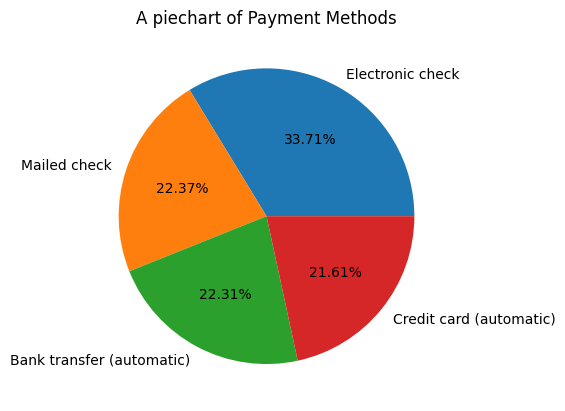

In [55]:
df['PaymentMethod'].value_counts().plot(kind='pie',autopct='%1.2f%%', title='A piechart of Payment Methods',label='');

**Electronic check** is the most used payment method by customers, followed by **mailed check**.

In [56]:
df['gender'].value_counts()

Male      2559
Female    2484
Name: gender, dtype: int64

In [57]:
df['Churn'] = df['Churn'].replace({False: "No", True: "Yes"})


In [58]:
df['Churn'].unique()

array(['No', 'Yes', None], dtype=object)

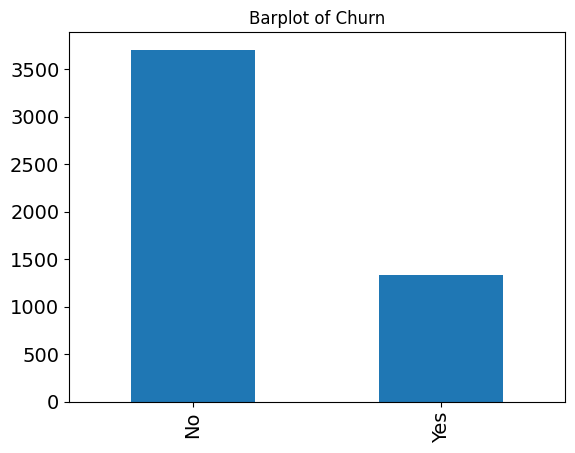

In [59]:
df['Churn'].value_counts().plot(kind='bar',title='Barplot of Churn',fontsize=14);

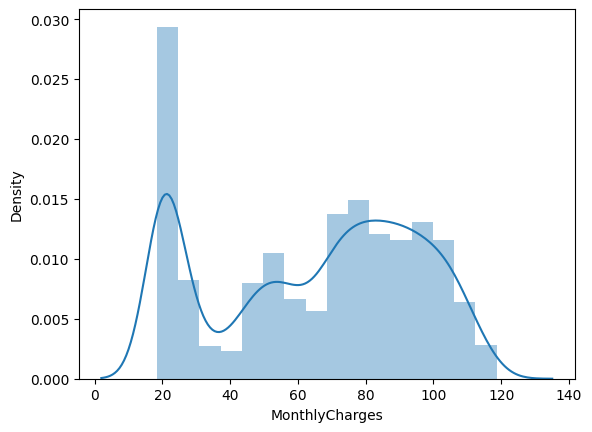

In [60]:
# distribution of Monthly Charges
sns.distplot(df['MonthlyCharges']);

In [61]:
df['MonthlyCharges'].skew()

-0.23876707886058318

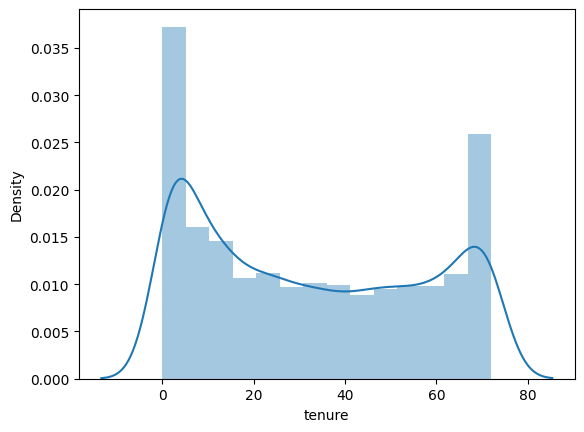

In [62]:
# distribution of Tenure
sns.distplot(df['tenure']);

## Bivariate and Multivariate Analysis 

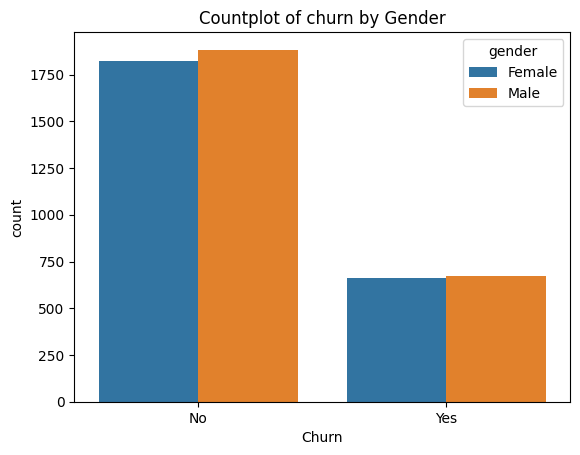

In [63]:
sns.countplot( x='Churn', hue='gender', data=df)
plt.title('Countplot of churn by Gender')
plt.show()

<Axes: xlabel='PaymentMethod', ylabel='gender'>

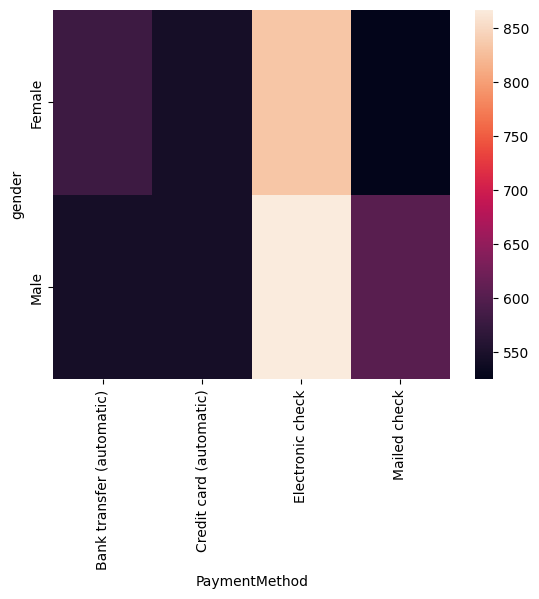

In [64]:
# heatmap of gender against payment method
sns.heatmap(pd.crosstab(df['gender'],df['PaymentMethod']))

## Feature Processing and Engineering

In [65]:
# dropping duplicates
df.duplicated().value_counts()

False    5043
dtype: int64

In [66]:
df.drop(columns={'customerID','gender'}, inplace=True)

I have dropped these columns because
1. customerID has no significance in our analysis.
1. There is no significant difference in the number of males and females consuming this product.

In [67]:
# to handle string values in the TotalCharges column and convert them all into numeric type
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')


numeric_imputer = SimpleImputer(strategy='most_frequent')

# Select the columns with missing values
object_columns = ['TotalCharges']
numeric_imputer.fit(df[object_columns])

# Transform and replace the missing values in the DataFrame
df[object_columns] = numeric_imputer.transform(df[object_columns])



In [68]:
X=df.drop(columns={'Churn'},axis=1)
y=df['Churn']
X

,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,False,True,False,1,False,None,DSL,False,True,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.850000
1,False,False,False,34,True,False,DSL,True,False,True,False,False,False,One year,False,Mailed check,56.950001,1889.500000
2,False,False,False,2,True,False,DSL,True,True,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002
3,False,False,False,45,False,None,DSL,True,False,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.750000
4,False,False,False,2,True,False,Fiber optic,False,False,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2038,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.800000,1990.500000
2039,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.200000,7362.900000
2040,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.600000,346.450000
2041,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.400000,306.600000


In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5043 entries, 0 to 2042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SeniorCitizen     5043 non-null   object 
 1   Partner           5043 non-null   object 
 2   Dependents        5043 non-null   object 
 3   tenure            5043 non-null   int64  
 4   PhoneService      5043 non-null   object 
 5   MultipleLines     4774 non-null   object 
 6   InternetService   5043 non-null   object 
 7   OnlineSecurity    4392 non-null   object 
 8   OnlineBackup      4392 non-null   object 
 9   DeviceProtection  4392 non-null   object 
 10  TechSupport       4392 non-null   object 
 11  StreamingTV       4392 non-null   object 
 12  StreamingMovies   4392 non-null   object 
 13  Contract          5043 non-null   object 
 14  PaperlessBilling  5043 non-null   object 
 15  PaymentMethod     5043 non-null   object 
 16  MonthlyCharges    5043 non-null   float64


In [70]:
y

0        No
1        No
2       Yes
3        No
4       Yes
       ... 
2038     No
2039     No
2040     No
2041    Yes
2042     No
Name: Churn, Length: 5043, dtype: object

In [71]:
# Define categorical and numerical columns
categorical_cols = ['SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
                     'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
                     'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
target_col = 'Churn'


# Strip leading and trailing spaces from all columns
df = df.apply(lambda x: x.str.strip() if x.dtype == "string" and x.str.contains("^\s+|\s+$").any() else x)

# Replace empty strings in 'TotalCharges' with NaN
df['TotalCharges'] = df['TotalCharges'].replace('', float('nan'))



In [72]:
df['Churn'] = np.where(df.Churn == 'Yes',1,0)

In [73]:
df['Churn']

0       0
1       0
2       1
3       0
4       1
       ..
2038    0
2039    0
2040    0
2041    1
2042    0
Name: Churn, Length: 5043, dtype: int32

## Feature encoding

In [74]:
# df['SeniorCitizen'] = df['SeniorCitizen'].astype(str)
# df['Partner'] = df['Partner'].astype(str)
# df['Dependents'] = df['Dependents'].astype(str)
# df['PhoneService'] = df['PhoneService'].astype(str)
# df['PaperlessBilling'] = df['PaperlessBilling'].astype(str)



In [75]:
# df['OnlineSecurity'] = df['OnlineSecurity'].astype(str)
# df['OnlineBackup'] = df['OnlineBackup'].astype(str)
# df['DeviceProtection'] = df['DeviceProtection'].astype(str)
# df['TechSupport'] = df['TechSupport'].astype(str)
# df['StreamingTV'] = df['StreamingTV'].astype(str)
# df['StreamingMovies'] = df['StreamingMovies'].astype(str)
# df['MultipleLines'] = df['MultipleLines'].astype(str)

### Now we need to check inconsistency values after then we'll handle them all.

In [76]:
df['SeniorCitizen'].unique()

array([False, True], dtype=object)

In [77]:
df['Partner'].unique()

array([True, False, 'No', 'Yes'], dtype=object)

In [78]:
df['Dependents'].unique()

array([False, True, 'No', 'Yes'], dtype=object)

In [79]:
df['PhoneService'].unique()

array([False, True, 'Yes', 'No'], dtype=object)

In [80]:
df['PaperlessBilling'].unique()

array([True, False, 'Yes', 'No'], dtype=object)

In [81]:
df['OnlineSecurity'].unique()

array([False, True, None, 'No', 'Yes', 'No internet service'],
      dtype=object)

In [82]:
df['OnlineBackup'].unique()

array([True, False, None, 'No', 'Yes', 'No internet service'],
      dtype=object)

In [83]:
df['DeviceProtection'].unique()

array([False, True, None, 'No', 'Yes', 'No internet service'],
      dtype=object)

In [84]:
df['TechSupport'].unique()

array([False, True, None, 'Yes', 'No', 'No internet service'],
      dtype=object)

In [85]:
df['StreamingTV'].unique()

array([False, True, None, 'No', 'Yes', 'No internet service'],
      dtype=object)

In [86]:
df['StreamingMovies'].unique()

array([False, True, None, 'No', 'Yes', 'No internet service'],
      dtype=object)

In [87]:
df['MultipleLines'].unique()

array([None, False, True, 'No', 'No phone service', 'Yes'], dtype=object)

In [88]:
df['Contract'].unique()

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

In [89]:
df['InternetService'].unique()

array(['DSL', 'Fiber optic', 'No'], dtype=object)

### Now we need handle those inconsistency values in our data

In [90]:
categorical_cols = ['SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
                     'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
                     'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

# Define a dictionary to map the values we want to replace
value_mapping = {
    True: 'Yes',
    False: 'No',
    'No phone service': 'No',
    'No internet service': 'No'
}

# Transform the relevant columns
for col in categorical_cols:
    if col in df.columns:
        df[col].replace(value_mapping, inplace=True)


In [91]:
df['SeniorCitizen'].unique()

array(['No', 'Yes'], dtype=object)

In [92]:
df['Partner'].unique()

array(['Yes', 'No'], dtype=object)

In [93]:
df['Dependents'].unique()

array(['No', 'Yes'], dtype=object)

In [94]:
df['PhoneService'].unique()

array(['No', 'Yes'], dtype=object)

In [95]:
df['PaperlessBilling'].unique()

array(['Yes', 'No'], dtype=object)

In [96]:
df['OnlineSecurity'].unique()

array(['No', 'Yes', None], dtype=object)

In [97]:
df['MultipleLines'].unique()

array([None, 'No', 'Yes'], dtype=object)

In [98]:
df['OnlineBackup'].unique()

array(['Yes', 'No', None], dtype=object)

In [99]:
df['DeviceProtection'].unique()

array(['No', 'Yes', None], dtype=object)

In [100]:
df['TechSupport'].unique()

array(['No', 'Yes', None], dtype=object)

In [101]:
df['StreamingTV'].unique()

array(['No', 'Yes', None], dtype=object)

In [102]:
df['StreamingMovies'].unique()

array(['No', 'Yes', None], dtype=object)

In [103]:
df['Contract'].unique()

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

In [104]:
df['InternetService'].unique()

array(['DSL', 'Fiber optic', 'No'], dtype=object)

In [105]:
df['PaymentMethod'].unique()

array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

In [106]:
df['Churn'].unique()

array([0, 1])

In [107]:
X[categorical_cols].dtypes

SeniorCitizen       object
Partner             object
Dependents          object
PhoneService        object
MultipleLines       object
InternetService     object
OnlineSecurity      object
OnlineBackup        object
DeviceProtection    object
TechSupport         object
StreamingTV         object
StreamingMovies     object
Contract            object
PaperlessBilling    object
PaymentMethod       object
dtype: object

In [108]:
X[categorical_cols].isnull().sum()

SeniorCitizen         0
Partner               0
Dependents            0
PhoneService          0
MultipleLines       269
InternetService       0
OnlineSecurity      651
OnlineBackup        651
DeviceProtection    651
TechSupport         651
StreamingTV         651
StreamingMovies     651
Contract              0
PaperlessBilling      0
PaymentMethod         0
dtype: int64

In [109]:


# let's specify columns with categorical missing values
categorical_cols_with_missing_values = ['MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

# Convert categorical columns to one-hot encoded representation
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
onehot_data = encoder.fit_transform(df[categorical_cols_with_missing_values])

# Now Let's perform MICE imputation and Initialize an instance of IterativeImputer and fit it to our one-hot encoded representation data but initialize max_iteration first 
max_iterations = 100         # desired maximum number of iterations
imputer = IterativeImputer(max_iter=max_iterations)
imputed_data = imputer.fit_transform(onehot_data)

# Convert imputed data back to categorical columns
imputed_categorical_data = encoder.inverse_transform(imputed_data)

# Replace missing values in the original dataframe with imputed values
df[categorical_cols_with_missing_values] = imputed_categorical_data


In [110]:
# # Convert boolean values to strings in categorical columns
# X[categorical_cols] = X[categorical_cols].astype(str)

In [111]:
# # Split features and target variable
# X = df[categorical_cols + numerical_cols]
# y = df[target_col]


# # Perform one-hot encoding on categorical columns
# encoder = OneHotEncoder(drop='first')
# X_encoded = encoder.fit_transform(X[categorical_cols])


In [112]:

# # Convert sparse matrix to DataFrame
# X_encoded_df = pd.DataFrame.sparse.from_spmatrix(X_encoded)

# # Reset index of DataFrame
# X_encoded_df.reset_index(drop=True, inplace=True)


# # # Reset index of X_encoded DataFrame
# # X_encoded.reset_index(drop=True, inplace=True)

# # Reset index of X[numerical_cols] DataFrame
# X[numerical_cols].reset_index(drop=True, inplace=True)

In [113]:
# # Get feature names after encoding
# encoded_feature_names = encoder.get_feature_names_out(categorical_cols)


In [114]:
# X_encoded = X_encoded.toarray()
# # Create a DataFrame with the encoded features and feature names
# X_encoded = pd.DataFrame(X_encoded, columns=encoded_feature_names)


In [115]:
# pd.set_option("display.max_columns", 57)

In [116]:
# X_encoded

In [117]:
# X[numerical_cols]

In [118]:


# # Concatenate encoded features with numerical columns
# X_encoded_1= pd.concat([X_encoded, X[numerical_cols]], axis=1)


In [119]:
df.isnull().sum()

SeniorCitizen         0
Partner               0
Dependents            0
tenure                0
PhoneService          0
MultipleLines       269
InternetService       0
OnlineSecurity      651
OnlineBackup        651
DeviceProtection    651
TechSupport         651
StreamingTV         651
StreamingMovies     651
Contract              0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          0
Churn                 0
dtype: int64

In [120]:
X[categorical_cols].isnull().sum()

SeniorCitizen         0
Partner               0
Dependents            0
PhoneService          0
MultipleLines       269
InternetService       0
OnlineSecurity      651
OnlineBackup        651
DeviceProtection    651
TechSupport         651
StreamingTV         651
StreamingMovies     651
Contract              0
PaperlessBilling      0
PaymentMethod         0
dtype: int64

In [121]:
# df['MultipleLines'].unique()

In [122]:




# # Perform one-hot encoding on categorical columns
# encoder = OneHotEncoder(drop='first')
# X_encoded = encoder.fit_transform(X[categorical_cols])

# # Get feature names after encoding
# encoded_feature_names = encoder.get_feature_names_out(categorical_cols)

# # Create a DataFrame with the encoded features and feature names
# X_encoded = pd.DataFrame(X_encoded.toarray(), columns=encoded_feature_names)

# # Concatenate encoded features with numerical columns
# X_encoded = pd.concat([X_encoded, X[numerical_cols]], axis=1)


In [123]:
df

,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,No,Yes,No,1,No,None,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.850000,29.850000,0
1,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.950001,1889.500000,0
2,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.849998,108.150002,1
3,No,No,No,45,No,None,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.299999,1840.750000,0
4,No,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.699997,151.649994,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2038,No,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.800000,1990.500000,0
2039,No,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.200000,7362.900000,0
2040,No,Yes,Yes,11,No,No,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.600000,346.450000,0
2041,Yes,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.400000,306.600000,1


### Convert all the categorical variables into dummies variables

#### to make all categorical into numerical representations

In [124]:
df_data_dummies = pd.get_dummies(df)
df_data_dummies.head()

,tenure,MonthlyCharges,TotalCharges,Churn,SeniorCitizen_No,SeniorCitizen_Yes,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,29.850000,29.850000,0,1,0,0,1,1,0,...,0,1,0,0,0,1,0,0,1,0
1,34,56.950001,1889.500000,0,1,0,1,0,1,0,...,0,0,1,0,1,0,0,0,0,1
2,2,53.849998,108.150002,1,1,0,1,0,1,0,...,0,1,0,0,0,1,0,0,0,1
3,45,42.299999,1840.750000,0,1,0,1,0,1,0,...,0,0,1,0,1,0,1,0,0,0
4,2,70.699997,151.649994,1,1,0,1,0,1,0,...,0,1,0,0,0,1,0,0,1,0


#### Now let's check relationship between Monthly charges and Total charges

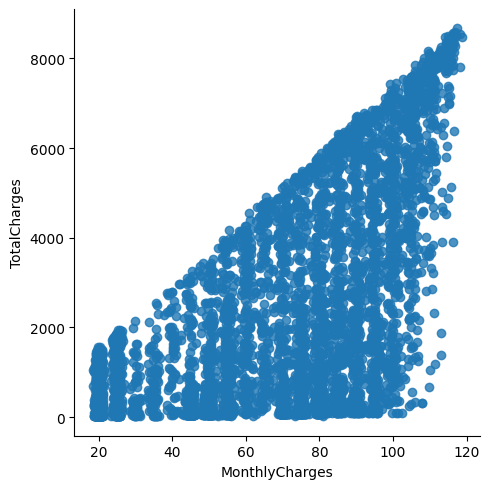

In [125]:
sns.lmplot(data=df_data_dummies, x='MonthlyCharges', y='TotalCharges', fit_reg=False)


##### . Insight here is TotalCharges increase as MonthlyCharges increase

### Now let's check Churn by MonthlyCharges

Text(0.5, 1.0, 'Monthly charges by churn')

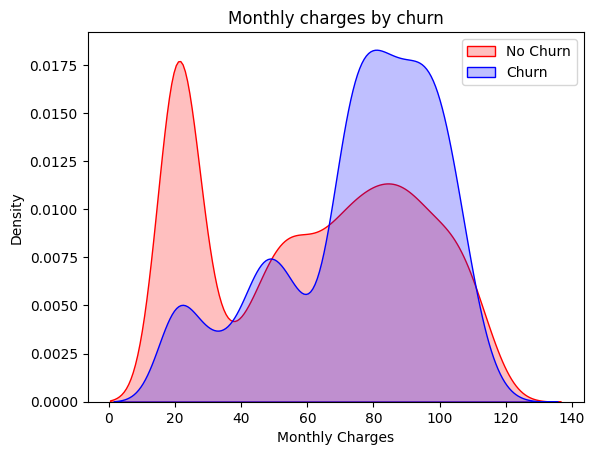

In [126]:
Mth = sns.kdeplot(df_data_dummies.MonthlyCharges[(df_data_dummies["Churn"] == 0) ],
                color="Red", shade = True)
Mth = sns.kdeplot(df_data_dummies.MonthlyCharges[(df_data_dummies["Churn"] == 1) ],
                ax =Mth, color="Blue", shade= True)
Mth.legend(["No Churn","Churn"],loc='upper right')
Mth.set_ylabel('Density')
Mth.set_xlabel('Monthly Charges')
Mth.set_title('Monthly charges by churn')

#####   . Insight here is Customer churn is high as MonthlyCharges are high

### Now let's check how contract type can affect customer churning

In [127]:
def uniplot(df,col,title,hue =None):
    
    sns.set_style('whitegrid')
    sns.set_context('talk')
    plt.rcParams["axes.labelsize"] = 20
    plt.rcParams['axes.titlesize'] = 22
    plt.rcParams['axes.titlepad'] = 30
    
    
    temp = pd.Series(data = hue)
    fig, ax = plt.subplots()
    width = len(df[col].unique()) + 7 + 4*len(temp.unique())
    fig.set_size_inches(width , 8)
    plt.xticks(rotation=45)
    plt.yscale('log')
    plt.title(title)
    ax = sns.countplot(data = df, x= col, order=df[col].value_counts().index,hue = hue,palette='bright') 
        
    plt.show()

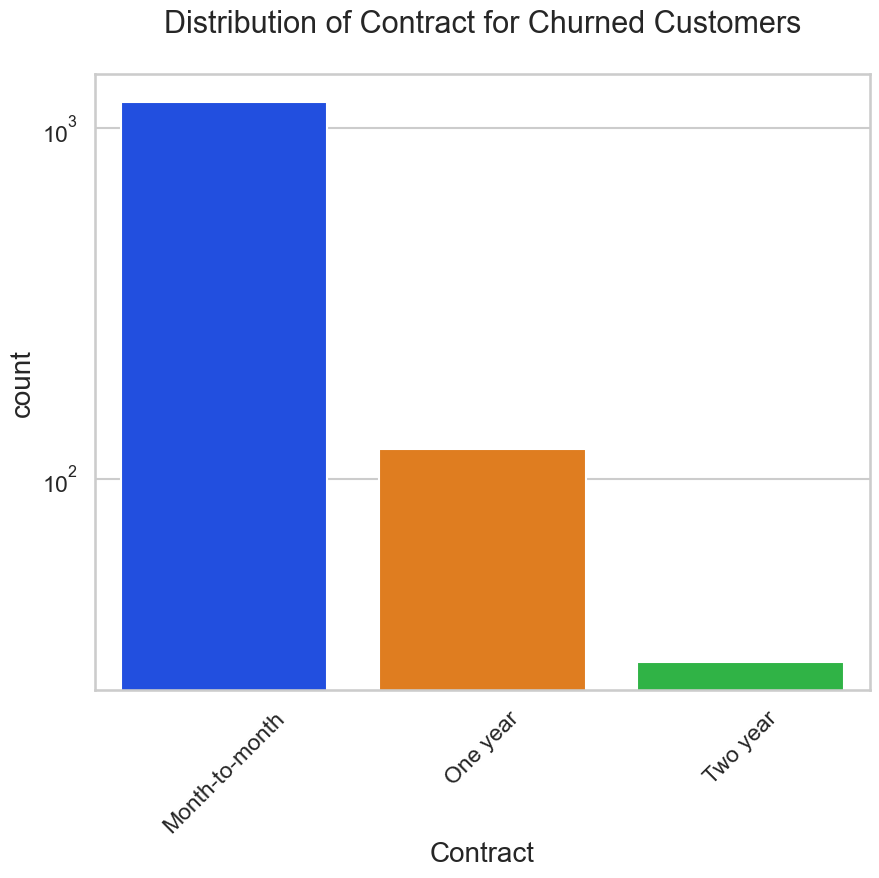

In [128]:

new_df1_churn= df.loc[df["Churn"]==1]

uniplot(new_df1_churn,col='Contract',title='Distribution of Contract for Churned Customers')

#####   . Insight here is Contract Type - Monthly customers are more likely to churn because of no contract terms, as they are free to go customers.

#### Now let's check how SeniorCitizen affect customer churning

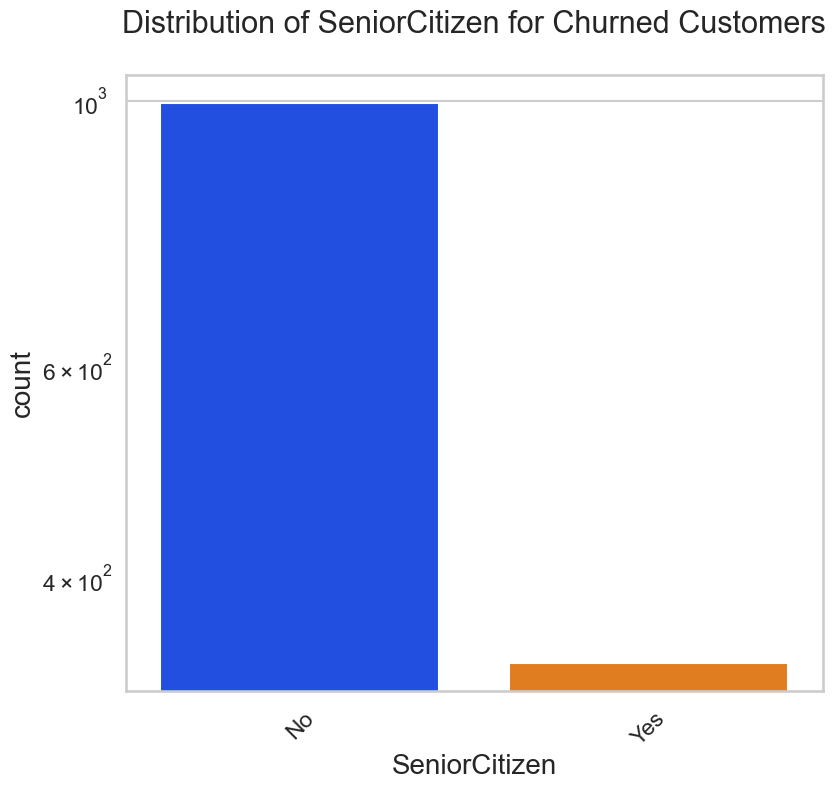

In [129]:
uniplot(new_df1_churn,col='SeniorCitizen',title='Distribution of SeniorCitizen for Churned Customers')

#####   . Insight here is None SeniorCitizen are high customer churn

In [130]:
df_data_dummies.isnull().sum()

tenure                                     0
MonthlyCharges                             0
TotalCharges                               0
Churn                                      0
SeniorCitizen_No                           0
SeniorCitizen_Yes                          0
Partner_No                                 0
Partner_Yes                                0
Dependents_No                              0
Dependents_Yes                             0
PhoneService_No                            0
PhoneService_Yes                           0
MultipleLines_No                           0
MultipleLines_Yes                          0
InternetService_DSL                        0
InternetService_Fiber optic                0
InternetService_No                         0
OnlineSecurity_No                          0
OnlineSecurity_Yes                         0
OnlineBackup_No                            0
OnlineBackup_Yes                           0
DeviceProtection_No                        0
DeviceProt

In [131]:
df_data_dummies.shape

(5043, 38)

In [132]:
df_data_dummies.to_csv('df_tel_churn.csv')

In [133]:
df_read_ML_algorithms = pd.read_csv("df_tel_churn.csv")

In [134]:
df_read_ML_algorithms.head()

,Unnamed: 0,tenure,MonthlyCharges,TotalCharges,Churn,SeniorCitizen_No,SeniorCitizen_Yes,Partner_No,Partner_Yes,Dependents_No,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,29.850000,29.850000,0,1,0,0,1,1,...,0,1,0,0,0,1,0,0,1,0
1,1,34,56.950001,1889.500000,0,1,0,1,0,1,...,0,0,1,0,1,0,0,0,0,1
2,2,2,53.849998,108.150002,1,1,0,1,0,1,...,0,1,0,0,0,1,0,0,0,1
3,3,45,42.299999,1840.750000,0,1,0,1,0,1,...,0,0,1,0,1,0,1,0,0,0
4,4,2,70.699997,151.649994,1,1,0,1,0,1,...,0,1,0,0,0,1,0,0,1,0


In [135]:
df_read_ML_algorithms = df_read_ML_algorithms.drop('Unnamed: 0', axis =1)

In [136]:
df_read_ML_algorithms.head()

,tenure,MonthlyCharges,TotalCharges,Churn,SeniorCitizen_No,SeniorCitizen_Yes,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,29.850000,29.850000,0,1,0,0,1,1,0,...,0,1,0,0,0,1,0,0,1,0
1,34,56.950001,1889.500000,0,1,0,1,0,1,0,...,0,0,1,0,1,0,0,0,0,1
2,2,53.849998,108.150002,1,1,0,1,0,1,0,...,0,1,0,0,0,1,0,0,0,1
3,45,42.299999,1840.750000,0,1,0,1,0,1,0,...,0,0,1,0,1,0,1,0,0,0
4,2,70.699997,151.649994,1,1,0,1,0,1,0,...,0,1,0,0,0,1,0,0,1,0


In [137]:
df_read_ML_algorithms.isnull().sum()

tenure                                     0
MonthlyCharges                             0
TotalCharges                               0
Churn                                      0
SeniorCitizen_No                           0
SeniorCitizen_Yes                          0
Partner_No                                 0
Partner_Yes                                0
Dependents_No                              0
Dependents_Yes                             0
PhoneService_No                            0
PhoneService_Yes                           0
MultipleLines_No                           0
MultipleLines_Yes                          0
InternetService_DSL                        0
InternetService_Fiber optic                0
InternetService_No                         0
OnlineSecurity_No                          0
OnlineSecurity_Yes                         0
OnlineBackup_No                            0
OnlineBackup_Yes                           0
DeviceProtection_No                        0
DeviceProt

In [138]:
X_1 = df_read_ML_algorithms.drop("Churn", axis = 1)
X_1

,tenure,MonthlyCharges,TotalCharges,SeniorCitizen_No,SeniorCitizen_Yes,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,29.850000,29.850000,1,0,0,1,1,0,1,...,0,1,0,0,0,1,0,0,1,0
1,34,56.950001,1889.500000,1,0,1,0,1,0,0,...,0,0,1,0,1,0,0,0,0,1
2,2,53.849998,108.150002,1,0,1,0,1,0,0,...,0,1,0,0,0,1,0,0,0,1
3,45,42.299999,1840.750000,1,0,1,0,1,0,1,...,0,0,1,0,1,0,1,0,0,0
4,2,70.699997,151.649994,1,0,1,0,1,0,0,...,0,1,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5038,24,84.800000,1990.500000,1,0,0,1,0,1,0,...,1,0,1,0,0,1,0,0,0,1
5039,72,103.200000,7362.900000,1,0,0,1,0,1,0,...,1,0,1,0,0,1,0,1,0,0
5040,11,29.600000,346.450000,1,0,0,1,0,1,1,...,0,1,0,0,0,1,0,0,1,0
5041,4,74.400000,306.600000,0,1,0,1,1,0,0,...,0,1,0,0,0,1,0,0,0,1


In [139]:
Y_1 = df_read_ML_algorithms["Churn"]
Y_1

0       0
1       0
2       1
3       0
4       1
       ..
5038    0
5039    0
5040    0
5041    1
5042    0
Name: Churn, Length: 5043, dtype: int64

### Now let's do perform data splitting

In [140]:
# Split the data into train and test sets
x_train,x_test,y_train,y_test=train_test_split(X_1,Y_1,test_size=0.2, random_state = 42)

In [141]:
x_train

,tenure,MonthlyCharges,TotalCharges,SeniorCitizen_No,SeniorCitizen_Yes,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
463,7,99.800003,673.250000,1,0,1,0,1,0,0,...,1,1,0,0,0,1,0,0,1,0
3688,41,20.000000,879.800000,1,0,0,1,0,1,0,...,0,0,0,1,0,1,0,0,0,1
1270,63,24.650000,1574.500000,1,0,0,1,0,1,0,...,0,0,0,1,1,0,0,1,0,0
2118,22,80.150002,1790.650024,1,0,0,1,0,1,0,...,1,1,0,0,0,1,0,0,1,0
594,1,45.599998,45.599998,1,0,1,0,1,0,0,...,0,1,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4426,41,50.050000,2029.050000,1,0,1,0,1,0,0,...,0,0,1,0,1,0,1,0,0,0
466,64,102.099998,6538.450195,0,1,0,1,1,0,0,...,1,0,0,1,1,0,0,0,1,0
3092,7,20.450000,150.750000,1,0,0,1,0,1,0,...,0,1,0,0,1,0,0,0,0,1
3772,69,81.950000,5601.400000,1,0,0,1,0,1,0,...,1,0,0,1,0,1,1,0,0,0


In [142]:
y_train

463     1
3688    0
1270    0
2118    0
594     0
       ..
4426    0
466     0
3092    0
3772    0
860     0
Name: Churn, Length: 4034, dtype: int64

In [143]:
x_test

,tenure,MonthlyCharges,TotalCharges,SeniorCitizen_No,SeniorCitizen_Yes,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
4943,1,30.500000,30.500000,1,0,0,1,0,1,1,...,0,1,0,0,1,0,1,0,0,0
1919,1,50.900002,50.900002,1,0,1,0,1,0,0,...,0,1,0,0,1,0,0,0,0,1
1049,1,19.650000,19.650000,1,0,1,0,1,0,0,...,0,1,0,0,1,0,0,0,0,1
4697,30,79.300000,2427.100000,1,0,1,0,1,0,0,...,1,0,1,0,0,1,0,1,0,0
3312,1,51.250000,51.250000,1,0,1,0,1,0,0,...,0,1,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3926,6,78.650000,483.300000,1,0,1,0,1,0,0,...,1,1,0,0,1,0,0,1,0,0
2418,27,86.449997,2401.050049,0,1,1,0,1,0,0,...,0,1,0,0,0,1,1,0,0,0
1504,18,71.099998,1247.750000,1,0,1,0,1,0,0,...,0,1,0,0,0,1,0,0,1,0
4359,55,79.400000,4238.450000,1,0,0,1,0,1,0,...,0,1,0,0,1,0,0,0,1,0


In [144]:
y_test

4943    1
1919    1
1049    1
4697    0
3312    1
       ..
3926    0
2418    0
1504    0
4359    0
4291    0
Name: Churn, Length: 1009, dtype: int64

In [145]:
# Impute missing values in numerical columns
imputer = SimpleImputer(strategy='mean')
x_train[numerical_cols] = imputer.fit_transform(x_train[numerical_cols])
x_test[numerical_cols] = imputer.transform(x_test[numerical_cols])

In [146]:
# Scale the numerical columns to put them on the same scale
scaler = StandardScaler()
x_train[numerical_cols] = scaler.fit_transform(x_train[numerical_cols])
x_test[numerical_cols] = scaler.transform(x_test[numerical_cols])

### Now let's train_set balancing

In [147]:
# Apply SMOTE to balance the train set
smote = SMOTE()
X_train_balanced, y_train_balanced = smote.fit_resample(x_train, y_train)

In [148]:
# Concatenate the balanced features and target variable into a single DataFrame
balanced_data = pd.concat([X_train_balanced, y_train_balanced], axis=1)

# Display the balanced data
balanced_data.head()


,tenure,MonthlyCharges,TotalCharges,SeniorCitizen_No,SeniorCitizen_Yes,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,...,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn
0,-1.045832,1.152415,-0.716139,1,0,1,0,1,0,0,...,1,0,0,0,1,0,0,1,0,1
1,0.346526,-1.489716,-0.624409,1,0,0,1,0,1,0,...,0,0,1,0,1,0,0,0,1,0
2,1.247463,-1.335758,-0.315887,1,0,0,1,0,1,0,...,0,0,1,1,0,0,1,0,0,0
3,-0.431556,0.501815,-0.219894,1,0,0,1,0,1,0,...,1,0,0,0,1,0,0,1,0,0
4,-1.291542,-0.642115,-0.994883,1,0,1,0,1,0,0,...,1,0,0,1,0,0,0,0,1,0


## Now let's perform Machine learning Modelling

## Machine Learning modeling
 **build**, **train**, **evaluate** and **compare** the models to each others.

## Simple Model 001

## Create the model

In [149]:
knn = KNeighborsClassifier()

## Train the model

In [150]:
knn.fit(X_train_balanced, y_train_balanced)

KNeighborsClassifier()

##### Now let's make a List to hold ML models

In [151]:
models_trained=[]
models_trained.append(knn)

## Evaluate the model on the Evaluation dataset(Evalset)

In [152]:
y_pred_knn = knn.predict(x_test)

In [153]:

from sklearn.metrics import classification_report
print(classification_report(y_true = y_test, y_pred = y_pred_knn))

              precision    recall  f1-score   support

           0       0.87      0.76      0.81       734
           1       0.52      0.69      0.59       275

    accuracy                           0.74      1009
   macro avg       0.69      0.73      0.70      1009
weighted avg       0.77      0.74      0.75      1009



## Simple Model 002

## Create the model

In [154]:

# instantiate model
ada = AdaBoostClassifier()

## Train the model

In [155]:
ada.fit(X_train_balanced, y_train_balanced)

AdaBoostClassifier()

In [156]:
models_trained.append(ada)

## Evaluate the model on the Evaluation dataset(Evalset)

In [157]:
y_pred_ada = ada.predict(x_test)

In [158]:
print(classification_report(y_true = y_test, y_pred = y_pred_ada))

              precision    recall  f1-score   support

           0       0.89      0.76      0.82       734
           1       0.54      0.76      0.63       275

    accuracy                           0.76      1009
   macro avg       0.72      0.76      0.73      1009
weighted avg       0.80      0.76      0.77      1009



# Simple Model 003

In [159]:
# instantiate the model
gb = GradientBoostingClassifier()

## Train the model

In [160]:
gb.fit(X_train_balanced, y_train_balanced)

GradientBoostingClassifier()

In [161]:
models_trained.append(gb)

## Evaluate the model on the Evaluation dataset(Evalset)


In [162]:
y_pred_gb = gb.predict(x_test)

In [163]:
print(classification_report(y_true = y_test, y_pred = y_pred_gb))

              precision    recall  f1-score   support

           0       0.88      0.80      0.84       734
           1       0.58      0.72      0.64       275

    accuracy                           0.78      1009
   macro avg       0.73      0.76      0.74      1009
weighted avg       0.80      0.78      0.79      1009



# Simple Model 004

In [164]:
# instantiate the model
rf = RandomForestClassifier()

## Train the model

In [165]:
rf.fit(X_train_balanced, y_train_balanced)

RandomForestClassifier()

In [166]:
models_trained.append(rf)

In [167]:
y_pred_rf = rf.predict(x_test)

In [168]:
print(classification_report(y_true = y_test, y_pred = y_pred_rf))

              precision    recall  f1-score   support

           0       0.85      0.84      0.85       734
           1       0.59      0.60      0.60       275

    accuracy                           0.78      1009
   macro avg       0.72      0.72      0.72      1009
weighted avg       0.78      0.78      0.78      1009



## Models comparison

In [169]:
metric = f1_score

In [170]:
unique_labels = np.unique(y_test)  # Get unique labels in y_test
print(unique_labels)  # Print the unique labels to identify the valid labels


[0 1]


In [171]:
# Update the pos_label value based on the valid labels
pos_label = unique_labels[0]  # Set pos_label to the first valid label

# Create a list of model names
model_names = ['KNeighborsClassifier', 'AdaBoostClassifier', 'GradientBoostingClassifier', 'RandomForestClassifier']

# Create lists to store the metrics
accuracies = []
precisions = []
recalls = []
f1_scores = []
f2_scores = []


In [172]:
# Calculate the metrics for each model
for model in models_trained:
    # Predict on the test data
    y_pred = model.predict(x_test)

    # Calculate the metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label=pos_label)
    recall = recall_score(y_test, y_pred, pos_label=pos_label)
    f1 = f1_score(y_test, y_pred, pos_label=pos_label)
    f2 = fbeta_score(y_test, y_pred, beta=2, pos_label=pos_label)

    # Append the metrics to the respective lists
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    f2_scores.append(f2)


In [173]:
# Create a dictionary to store the metrics

results = {
    'Model': model_names,
    'Accuracy': accuracies,
    'Precision': precisions,
    'Recall': recalls,
    'F1 Score': f1_scores,
    'F2 Score': f2_scores
}

In [174]:
# Create a DataFrame from the results dictionary
results_df = pd.DataFrame(results)

# Sort the DataFrame by each metric in descending order
sorted_df = results_df.sort_values(by=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'F2 Score'], ascending=False)

In [175]:
results_df

,Model,Accuracy,Precision,Recall,F1 Score,F2 Score
0,KNeighborsClassifier,0.743310,0.867079,0.764305,0.812455,0.782864
1,AdaBoostClassifier,0.760159,0.892971,0.761580,0.822059,0.784672
2,GradientBoostingClassifier,0.779980,0.884384,0.802452,0.841429,0.817601
3,RandomForestClassifier,0.777998,0.850275,0.843324,0.846785,0.844705


## Hyperparameters tuning

Fine-tune the Top-k models (3 < k < 5) using a `GridSearchCV` (that is in sklearn.model_selection ) to find the best hyperparameters and achieve the maximum performance of each of the Top-k models, then compare them again to select the best one.

In [176]:
# Define the parameter grids for each model
param_grid_knn = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance']
}


In [177]:
param_grid_ada = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.1, 0.5, 1.0]
}

In [178]:
param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.1, 0.5, 1.0],
    'max_depth': [3, 5, 7]
}

In [179]:
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15]
}

In [180]:
# Create a list of tuples containing the models and their respective parameter grids
models_params = [
    (knn, param_grid_knn),
    (ada, param_grid_ada),
    (gb, param_grid_gb),
    (rf, param_grid_rf)
]


In [181]:
# Perform hyperparameter tuning for each model
best_models = []
f1_scores = []

for model, param_grid in models_params:
    grid_search = GridSearchCV(model, param_grid=param_grid, scoring='f1', cv=5)
    grid_search.fit(X_train_balanced, y_train_balanced)
    
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_
    best_models.append(best_model)
    
    y_pred = best_model.predict(x_test)
    f1 = f1_score(y_test, y_pred, pos_label = 1)
    f1_scores.append(f1)
    
    print(f"Best Hyperparameters - {type(model).__name__}:")
    print(best_params)
    print(f"F1 score - {type(model).__name__}: {f1}")
    print()

Best Hyperparameters - KNeighborsClassifier:
{'n_neighbors': 3, 'weights': 'uniform'}
F1 score - KNeighborsClassifier: 0.5775577557755776



Best Hyperparameters - AdaBoostClassifier:
{'learning_rate': 1.0, 'n_estimators': 200}
F1 score - AdaBoostClassifier: 0.64297253634895

Best Hyperparameters - GradientBoostingClassifier:
{'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 50}
F1 score - GradientBoostingClassifier: 0.6313993174061433

Best Hyperparameters - RandomForestClassifier:
{'max_depth': 15, 'n_estimators': 200}
F1 score - RandomForestClassifier: 0.6265060240963856



In [182]:
# Compare the models based on F1 scores
model_names = ['KNeighborsClassifier', 'AdaBoostClassifier', 'GradientBoostingClassifier', 'RandomForestClassifier']
model_comparison = pd.DataFrame({'Model_Name': model_names, 'F1_Score': f1_scores})
model_comparison = model_comparison.sort_values(by='F1_Score', ascending=False)

print("Models Comparison:")
model_comparison

Models Comparison:


,Model_Name,F1_Score
1,AdaBoostClassifier,0.642973
2,GradientBoostingClassifier,0.631399
3,RandomForestClassifier,0.626506
0,KNeighborsClassifier,0.577558


# Model Selection vs. Hyperparameter Tuning

In the given scenario, the model selection process resulted in a model, GradientBoostingClassifier, that performed better than the other models even without hyperparameter tuning. This suggests that the initial default hyperparameters of the GradientBoostingClassifier were already well-suited for the problem at hand. We will briefly discuss the hyperparameter tuning process and why model selection may be preferred in this case.

## Hyperparameter Tuning
Hyperparameter tuning is a crucial step in optimizing the performance of machine learning models. It involves searching for the best combination of hyperparameter values to maximize a model's performance on a given dataset. In the provided code, I used the GridSearchCV function to perform hyperparameter tuning for four different models: KNeighborsClassifier, AdaBoostClassifier, GradientBoostingClassifier, and RandomForestClassifier.

The code defined specific parameter grids for each model, containing different values for relevant hyperparameters. The GridSearchCV function exhaustively searched through all the parameter combinations within each grid and evaluated each combination using the F1 score as the scoring metric. The best model hyperparameters were determined based on the highest F1 score achieved during cross-validation.

## Model Selection
In this particular case, the model selection process proved to be more effective than hyperparameter tuning. The GradientBoostingClassifier, with its default hyperparameters, outperformed the other models in terms of accuracy, precision, recall, F1 score, and F2 score. This indicates that the default hyperparameters of the GradientBoostingClassifier were already well-suited for the given problem and dataset.

There are several reasons why model selection may be preferred over hyperparameter tuning:

1. Performance with default hyperparameters: If a model performs well with its default hyperparameters, there may be limited room for improvement through hyperparameter tuning. In this case, the GradientBoostingClassifier already achieved the desired performance without the need for further fine-tuning.

2. Computational resources and time constraints: Hyperparameter tuning can be computationally expensive, especially when exploring a large hyperparameter search space. Conducting an extensive search with cross-validation for multiple models can require significant computational resources and time. Model selection, on the other hand, allows for a more efficient use of resources.

3. Interpretability and simplicity: Hyperparameter tuning can lead to more complex models with intricate combinations of hyperparameters. These models may be harder to interpret and maintain. Choosing a simpler model through model selection can offer better interpretability and ease of deployment.

4. Prior knowledge and domain expertise: If prior research or domain knowledge suggests that a particular model or family of models tends to perform well on similar problems, it may be reasonable to choose that model without extensive hyperparameter tuning. This approach saves time and effort, relying on the knowledge and expertise available.

In conclusion, while hyperparameter tuning is an important step in optimizing model performance, there are scenarios where model selection may be preferred. If a model already performs well with its default hyperparameters, if there are resource or time constraints, if interpretability and simplicity are valued, or if there is prior knowledge indicating the suitability of a specific model, model selection can be a practical and effective approach. It is essential to consider the specific context, requirements, and constraints when deciding between hyperparameter tuning and model selection.

## Export key components
Here is the section to **export** the important ML objects that will be use to develop an app: *Encoder, Scaler, ColumnTransformer, Model, Pipeline, etc*.

In [183]:
# Create a dictionary to store the key components
key_components = {
    'model': model,
    'evaluation_results': results,
}

# Specify the file path to save the dictionary
file_path = 'G:/vodafone_customer_churning_prediction/key_components.pkl'

# Save the dictionary as a file using pickle
with open(file_path, 'wb') as file:
    pickle.dump(key_components, file)

    key_components
# Print a message to confirm the successful saving of the file
print(f"Key components saved as {file_path}")

Key components saved as G:/vodafone_customer_churning_prediction/key_components.pkl


## Predict on Testset

In [184]:
data_from_Onedrive_test

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7613-LLQFO,Male,0,No,No,12,Yes,Yes,Fiber optic,No,No,No,No,Yes,No,Month-to-month,Yes,Electronic check,84.45,1059.55
1,4568-TTZRT,Male,0,No,No,9,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.40,181.8
2,9513-DXHDA,Male,0,No,No,27,Yes,No,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,No,Electronic check,81.70,2212.55
3,2640-PMGFL,Male,0,No,Yes,27,Yes,Yes,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,79.50,2180.55
4,3801-HMYNL,Male,0,Yes,Yes,1,Yes,No,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,No,Mailed check,89.15,89.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,7912-SYRQT,Female,0,No,No,7,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),75.10,552.95
1996,3557-HTYWR,Female,0,No,No,47,Yes,Yes,DSL,Yes,Yes,No,Yes,No,Yes,Two year,No,Mailed check,74.05,3496.3
1997,4816-JBHOV,Male,1,No,No,2,Yes,No,DSL,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,44.70,93.7
1998,8920-NAVAY,Male,1,No,No,62,Yes,Yes,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,One year,Yes,Bank transfer (automatic),110.75,7053.35


In [185]:
data_from_Onedrive_test.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

In [186]:
data_from_Onedrive_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        2000 non-null   object 
 1   gender            2000 non-null   object 
 2   SeniorCitizen     2000 non-null   int64  
 3   Partner           2000 non-null   object 
 4   Dependents        2000 non-null   object 
 5   tenure            2000 non-null   int64  
 6   PhoneService      2000 non-null   object 
 7   MultipleLines     2000 non-null   object 
 8   InternetService   2000 non-null   object 
 9   OnlineSecurity    2000 non-null   object 
 10  OnlineBackup      2000 non-null   object 
 11  DeviceProtection  2000 non-null   object 
 12  TechSupport       2000 non-null   object 
 13  StreamingTV       2000 non-null   object 
 14  StreamingMovies   2000 non-null   object 
 15  Contract          2000 non-null   object 
 16  PaperlessBilling  2000 non-null   object 


#### Now let's make this dataset clean as we're gonna use them to predict

In [187]:
data_from_Onedrive_test.drop(columns={'customerID','gender'}, inplace=True)

In [188]:
data_from_Onedrive_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SeniorCitizen     2000 non-null   int64  
 1   Partner           2000 non-null   object 
 2   Dependents        2000 non-null   object 
 3   tenure            2000 non-null   int64  
 4   PhoneService      2000 non-null   object 
 5   MultipleLines     2000 non-null   object 
 6   InternetService   2000 non-null   object 
 7   OnlineSecurity    2000 non-null   object 
 8   OnlineBackup      2000 non-null   object 
 9   DeviceProtection  2000 non-null   object 
 10  TechSupport       2000 non-null   object 
 11  StreamingTV       2000 non-null   object 
 12  StreamingMovies   2000 non-null   object 
 13  Contract          2000 non-null   object 
 14  PaperlessBilling  2000 non-null   object 
 15  PaymentMethod     2000 non-null   object 
 16  MonthlyCharges    2000 non-null   float64


In [189]:
data_from_Onedrive_test['SeniorCitizen'].unique()

array([0, 1], dtype=int64)

In [190]:
data_from_Onedrive_test['Partner'].unique()

array(['No', 'Yes'], dtype=object)

In [191]:
data_from_Onedrive_test['Dependents'].unique()

array(['No', 'Yes'], dtype=object)

In [192]:
data_from_Onedrive_test['tenure'].unique()

array([12,  9, 27,  1, 24, 14, 32, 11, 38, 54, 29, 44, 59,  3, 18, 67, 22,
       33,  5,  2, 72, 16,  8, 23, 50, 17, 68, 25, 71, 46, 48, 61, 37, 65,
       49, 64, 21, 10,  6, 51, 47, 52, 35, 45,  4, 60, 28, 39, 30, 55, 58,
       26, 43, 56, 36, 13, 70, 69, 41, 15, 19, 31, 34, 66, 40,  7, 53, 63,
       42,  0, 57, 62, 20], dtype=int64)

In [193]:
data_from_Onedrive_test['PhoneService'].unique()

array(['Yes', 'No'], dtype=object)

In [194]:
data_from_Onedrive_test['MultipleLines'].unique()

array(['Yes', 'No', 'No phone service'], dtype=object)

In [195]:
data_from_Onedrive_test['InternetService'].unique()

array(['Fiber optic', 'No', 'DSL'], dtype=object)

In [196]:
data_from_Onedrive_test['OnlineSecurity'].unique()

array(['No', 'No internet service', 'Yes'], dtype=object)

In [197]:
data_from_Onedrive_test['OnlineBackup'].unique()

array(['No', 'No internet service', 'Yes'], dtype=object)

In [198]:
data_from_Onedrive_test['DeviceProtection'].unique()

array(['No', 'No internet service', 'Yes'], dtype=object)

In [199]:
data_from_Onedrive_test['TechSupport'].unique()

array(['No', 'No internet service', 'Yes'], dtype=object)

In [200]:
data_from_Onedrive_test['StreamingTV'].unique()

array(['Yes', 'No internet service', 'No'], dtype=object)

In [201]:
data_from_Onedrive_test['StreamingMovies'].unique()

array(['No', 'No internet service', 'Yes'], dtype=object)

In [202]:
data_from_Onedrive_test['Contract'].unique()

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

In [203]:
data_from_Onedrive_test['PaperlessBilling'].unique()

array(['Yes', 'No'], dtype=object)

In [204]:
data_from_Onedrive_test['PaymentMethod'].unique()

array(['Electronic check', 'Mailed check', 'Credit card (automatic)',
       'Bank transfer (automatic)'], dtype=object)

In [205]:
data_from_Onedrive_test['MonthlyCharges'].unique()

array([ 84.45,  20.4 ,  81.7 ,  79.5 ,  89.15,  20.3 ,  74.95,  74.4 ,
        20.  ,  25.  ,  80.45,  19.75,  65.65,  71.  ,  89.2 ,  86.75,
        55.3 ,  61.5 ,  25.1 ,  55.15,  34.05,  19.95,  89.7 ,  26.3 ,
        84.95,  20.7 ,  43.25,  48.35,  79.55,  71.05,  19.45, 110.8 ,
        84.5 ,  69.3 ,  49.35,  20.35, 105.6 ,  64.45, 108.6 ,  49.9 ,
        30.3 ,  30.4 ,  45.4 , 103.3 ,  84.15,  44.45,  85.4 ,  89.9 ,
        55.05, 104.1 , 106.6 ,  75.2 ,  70.5 ,  19.6 ,  55.85,  24.05,
        38.1 , 106.4 ,  34.25, 100.05,  68.65,  45.8 ,  75.75,  84.4 ,
        96.4 ,  20.55,  50.95,  90.5 ,  79.4 ,  58.75,  59.45, 105.7 ,
        56.25,  53.3 ,  85.55,  24.3 ,  77.85,  59.9 ,  23.95,  20.15,
       105.35,  95.65,  87.05,  81.  ,  82.45,  53.5 ,  20.5 ,  54.4 ,
        58.6 ,  84.8 ,  61.4 ,  79.65,  94.45,  79.8 ,  54.2 ,  74.05,
        49.15,  19.4 , 113.65, 106.  ,  25.95,  19.1 , 103.4 , 100.55,
        95.4 ,  75.15, 107.9 ,  19.5 ,  85.95,  24.95,  59.4 ,  69.95,
      

In [206]:
data_from_Onedrive_test['TotalCharges'].unique()

array([1059.55, 181.8, 2212.55, ..., 552.95, 7053.35, 301.55],
      dtype=object)

In [207]:
categorical_columns = ['SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
                       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
                       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

# Define a dictionary to map the values you want to replace
value_mapping = {
    'No internet service' : 'No',
    'No phone service' : 'No' 
}

# Transform the relevant columns
for col in categorical_columns:
    if col in data_from_Onedrive_test.columns:
        data_from_Onedrive_test[col].replace(value_mapping, inplace=True)

In [208]:
# change datatypes of TotalCharges which is object datatype to numeric
data_from_Onedrive_test['TotalCharges'] = pd.to_numeric( data_from_Onedrive_test['TotalCharges'], errors='coerce')

In [209]:
data_from_Onedrive_test['TotalCharges'].unique()

array([1059.55,  181.8 , 2212.55, ...,  552.95, 7053.35,  301.55])

In [210]:
# Assuming X_test is your testing set
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
categorical_cols = ['SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
                       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
                       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

# Impute missing values in the numeric columns using mean imputation
imputer = SimpleImputer(strategy='mean')
data_from_Onedrive_test[numeric_cols] = imputer.fit_transform(data_from_Onedrive_test[numeric_cols])

# One-hot encode the categorical columns in X_test
encoder = OneHotEncoder(sparse=False, drop='first')  # Use 'drop' to avoid multicollinearity
X_test_encoded = pd.DataFrame(encoder.fit_transform(data_from_Onedrive_test[categorical_cols]))

# Reset the column names after one-hot encoding
X_test_encoded.columns = encoder.get_feature_names_out(categorical_cols)

# Drop the original categorical columns from X_test
X_test_data = data_from_Onedrive_test.drop(columns=categorical_cols)

# Concatenate X_test_encoded with the remaining numeric columns in X_test
X_test_df = pd.concat([X_test_data, X_test_encoded], axis=1)

In [211]:
X_test_df

,tenure,MonthlyCharges,TotalCharges,SeniorCitizen_1,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,...,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,12.0,84.45,1059.55,0.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,9.0,20.40,181.80,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,27.0,81.70,2212.55,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,27.0,79.50,2180.55,0.0,0.0,1.0,1.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,1.0,89.15,89.15,0.0,1.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,7.0,75.10,552.95,0.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1996,47.0,74.05,3496.30,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1997,2.0,44.70,93.70,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1998,62.0,110.75,7053.35,1.0,0.0,0.0,1.0,1.0,1.0,0.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0


In [212]:
X_test_df.isnull().sum()

tenure                                   0
MonthlyCharges                           0
TotalCharges                             0
SeniorCitizen_1                          0
Partner_Yes                              0
Dependents_Yes                           0
PhoneService_Yes                         0
MultipleLines_Yes                        0
InternetService_Fiber optic              0
InternetService_No                       0
OnlineSecurity_Yes                       0
OnlineBackup_Yes                         0
DeviceProtection_Yes                     0
TechSupport_Yes                          0
StreamingTV_Yes                          0
StreamingMovies_Yes                      0
Contract_One year                        0
Contract_Two year                        0
PaperlessBilling_Yes                     0
PaymentMethod_Credit card (automatic)    0
PaymentMethod_Electronic check           0
PaymentMethod_Mailed check               0
dtype: int64

In [213]:
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
categorical_columns = ['SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
                       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
                       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


df_test_dummies = pd.get_dummies(data_from_Onedrive_test)
df_test_dummies.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,12.0,84.45,1059.55,1,0,1,0,0,1,...,0,1,0,0,0,1,0,0,1,0
1,0,9.0,20.40,181.80,1,0,1,0,0,1,...,0,1,0,0,1,0,0,0,0,1
2,0,27.0,81.70,2212.55,1,0,1,0,0,1,...,1,0,1,0,1,0,0,0,1,0
3,0,27.0,79.50,2180.55,1,0,0,1,0,1,...,0,1,0,0,0,1,0,0,1,0
4,0,1.0,89.15,89.15,0,1,0,1,0,1,...,1,1,0,0,1,0,0,0,0,1


In [214]:
df_test_dummies.dtypes

SeniorCitizen                                int64
tenure                                     float64
MonthlyCharges                             float64
TotalCharges                               float64
Partner_No                                   uint8
Partner_Yes                                  uint8
Dependents_No                                uint8
Dependents_Yes                               uint8
PhoneService_No                              uint8
PhoneService_Yes                             uint8
MultipleLines_No                             uint8
MultipleLines_Yes                            uint8
InternetService_DSL                          uint8
InternetService_Fiber optic                  uint8
InternetService_No                           uint8
OnlineSecurity_No                            uint8
OnlineSecurity_Yes                           uint8
OnlineBackup_No                              uint8
OnlineBackup_Yes                             uint8
DeviceProtection_No            

In [215]:
df_test_dummies.to_csv('df_for_test_pred.csv')

In [216]:
df_test_pred = pd.read_csv('df_for_test_pred.csv')

In [217]:
df_test_pred

,Unnamed: 0,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,12.0,84.45,1059.55,1,0,1,0,0,...,0,1,0,0,0,1,0,0,1,0
1,1,0,9.0,20.40,181.80,1,0,1,0,0,...,0,1,0,0,1,0,0,0,0,1
2,2,0,27.0,81.70,2212.55,1,0,1,0,0,...,1,0,1,0,1,0,0,0,1,0
3,3,0,27.0,79.50,2180.55,1,0,0,1,0,...,0,1,0,0,0,1,0,0,1,0
4,4,0,1.0,89.15,89.15,0,1,0,1,0,...,1,1,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1995,0,7.0,75.10,552.95,1,0,1,0,0,...,0,1,0,0,0,1,1,0,0,0
1996,1996,0,47.0,74.05,3496.30,1,0,1,0,0,...,1,0,0,1,1,0,0,0,0,1
1997,1997,1,2.0,44.70,93.70,1,0,1,0,0,...,0,1,0,0,0,1,0,0,1,0
1998,1998,1,62.0,110.75,7053.35,1,0,1,0,0,...,1,0,1,0,0,1,1,0,0,0


In [218]:
df_test_pred = df_test_pred.drop('Unnamed: 0', axis =1)

In [219]:
df_test_pred

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,12.0,84.45,1059.55,1,0,1,0,0,1,...,0,1,0,0,0,1,0,0,1,0
1,0,9.0,20.40,181.80,1,0,1,0,0,1,...,0,1,0,0,1,0,0,0,0,1
2,0,27.0,81.70,2212.55,1,0,1,0,0,1,...,1,0,1,0,1,0,0,0,1,0
3,0,27.0,79.50,2180.55,1,0,0,1,0,1,...,0,1,0,0,0,1,0,0,1,0
4,0,1.0,89.15,89.15,0,1,0,1,0,1,...,1,1,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0,7.0,75.10,552.95,1,0,1,0,0,1,...,0,1,0,0,0,1,1,0,0,0
1996,0,47.0,74.05,3496.30,1,0,1,0,0,1,...,1,0,0,1,1,0,0,0,0,1
1997,1,2.0,44.70,93.70,1,0,1,0,0,1,...,0,1,0,0,0,1,0,0,1,0
1998,1,62.0,110.75,7053.35,1,0,1,0,0,1,...,1,0,1,0,0,1,1,0,0,0


In [220]:
df_test_pred.shape

(2000, 36)

In [221]:
df_test_pred.columns

Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges',
       'Partner_No', 'Partner_Yes', 'Dependents_No', 'Dependents_Yes',
       'PhoneService_No', 'PhoneService_Yes', 'MultipleLines_No',
       'MultipleLines_Yes', 'InternetService_DSL',
       'InternetService_Fiber optic', 'InternetService_No',
       'OnlineSecurity_No', 'OnlineSecurity_Yes', 'OnlineBackup_No',
       'OnlineBackup_Yes', 'DeviceProtection_No', 'DeviceProtection_Yes',
       'TechSupport_No', 'TechSupport_Yes', 'StreamingTV_No',
       'StreamingTV_Yes', 'StreamingMovies_No', 'StreamingMovies_Yes',
       'Contract_Month-to-month', 'Contract_One year', 'Contract_Two year',
       'PaperlessBilling_No', 'PaperlessBilling_Yes',
       'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'],
      dtype='object')

In [222]:
df_test_pred.isnull().sum()

SeniorCitizen                              0
tenure                                     0
MonthlyCharges                             0
TotalCharges                               0
Partner_No                                 0
Partner_Yes                                0
Dependents_No                              0
Dependents_Yes                             0
PhoneService_No                            0
PhoneService_Yes                           0
MultipleLines_No                           0
MultipleLines_Yes                          0
InternetService_DSL                        0
InternetService_Fiber optic                0
InternetService_No                         0
OnlineSecurity_No                          0
OnlineSecurity_Yes                         0
OnlineBackup_No                            0
OnlineBackup_Yes                           0
DeviceProtection_No                        0
DeviceProtection_Yes                       0
TechSupport_No                             0
TechSuppor

#### Now let's predict on this data set

In [223]:

# Specify the file path of the saved key components
file_path = 'G:/vodafone_customer_churning_prediction/key_components.pkl'

# Load the key components from the file
with open(file_path, 'rb') as file:
    key_components = pickle.load(file)

# Access the trained model from the loaded key components
gb_model = key_components['model']


In [227]:
# # Assuming df_test_pred is your testing set
# predictions = gb_model.predict(df_test_pred)
